In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import os
import pandas as pd
import numpy as np
import warnings
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
# from imblearn.combine import SMOTETomek  # alternativa híbrida
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import BernoulliNB
import numpy as np


import joblib
from datetime import datetime

warnings.filterwarnings('ignore')

In [18]:
# Leer archivo parquet
df = pd.read_parquet(r'C:\Users\Admin\Downloads\Colsubsidio\plata\preprocesada.parquet')

print(df.shape)   # filas y columnas
df.head()  # primeras filas


(46602, 20)


,Target,Disponible.Avances,Total.Intereses,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Pago.del.Mes,Vr.Mora,Saldo,edad,PAC,contrato,cuota_monetaria,segmento_Alto,segmento_Medio,nivel_educativo_secundaria,estado_civil_casado,estado_civil_soltero,Genero_M,categoria_C
id,,,,,,,,,,,,,,,,,,,,
1,0,1050000.0,0.0,0.0,0.0,0,0.0,0.0,0.0,31,1,4,0,0,1,0,0,1,0,0
2,0,1180000.0,0.0,0.0,0.0,0,0.0,0.0,0.0,38,1,1,0,0,1,0,0,1,1,1
3,0,150000.0,0.0,0.0,0.0,0,0.0,0.0,0.0,42,3,3,1,0,0,0,0,1,1,0
4,0,680000.0,0.0,0.0,0.0,0,0.0,0.0,0.0,60,1,4,0,0,1,0,0,1,1,0
5,0,3307500.0,0.0,0.0,0.0,0,0.0,0.0,0.0,27,1,1,0,1,0,0,0,0,1,1


In [19]:
df.groupby('Target').size()/len(df)  # distribución de clases

Target
0    0.969701
1    0.030299
dtype: float64

In [20]:
mm=int(df.groupby('Target').size()[0]*0.40)
m=int(df.groupby('Target').size()[1])
print(mm,m)

18076 1412


In [21]:
#Generacion Muestra
df1=df.copy()
c0 = df1[df1['Target'] == 0].sample(n=mm)  
c1 = df1[df1['Target'] == 1].sample(n=m)  
pdList = [c0,c1]  # List of your dataframes
df1 = pd.concat(pdList)
print(df1.groupby('Target').size())

Target
0    18076
1     1412
dtype: int64


In [22]:
df=df1.copy()

In [23]:
# ==== 0) Split (estratificado) ====
features = [c for c in df.columns if c != 'Target']
X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# ==== 1) Elegir modo de balanceo ====
USE_SMOTE = True  # <- cambia a False si prefieres no oversampling y usar class_weight/scale_pos_weight

# ratio para modelos con pesos si NO usamos SMOTE
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
ratio = neg / max(1, pos)  # n_neg/n_pos

def make_models(USE_SMOTE: bool):
    if USE_SMOTE:
        # Con oversampling (SMOTE): no uses class_weight/scale_pos_weight
        smote = SMOTE(random_state=42, k_neighbors=5)
        return {
            'LogisticRegression': ImbPipeline(steps=[
                ('smote', smote),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))
            ]),
            'DecisionTree': ImbPipeline(steps=[
                ('smote', smote),
                ('clf', DecisionTreeClassifier(max_depth=6, random_state=42))
            ]),
            'RandomForest': ImbPipeline(steps=[
                ('smote', smote),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42))
            ]),
            'XGBoost': ImbPipeline(steps=[
                ('smote', smote),
                ('clf', XGBClassifier(
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='logloss'
                ))
            ]),
            'LightGBM': ImbPipeline(steps=[
                ('smote', smote),
                ('clf', LGBMClassifier(random_state=42))
            ]),
            'BernoulliNB': ImbPipeline(steps=[
                ('smote', smote),
                ('clf', BernoulliNB(alpha=1e-3))
            ])
        }
    else:
        # Sin oversampling: usa class_weight/scale_pos_weight
        cw = 'balanced'
        return {
            'LogisticRegression': LogisticRegression(max_iter=1000, class_weight=cw, random_state=42),
            'DecisionTree'      : DecisionTreeClassifier(max_depth=6, class_weight=cw, random_state=42),
            'RandomForest'      : RandomForestClassifier(n_estimators=200, max_depth=6, class_weight=cw, random_state=42),
            'XGBoost'           : XGBClassifier(
                                    random_state=42, use_label_encoder=False, eval_metric='logloss',
                                    scale_pos_weight=ratio  # n_neg / n_pos
                                  ),
            'LightGBM'          : LGBMClassifier(random_state=42, class_weight={0:1, 1:ratio}),
            'BernoulliNB'       : BernoulliNB(alpha=1e-3)  # no tiene class_weight; podrías pasar sample_weight en .fit si quisieras
        }

models = make_models(USE_SMOTE)

(13641, 19) (5847, 19) (13641,) (5847,)


[LightGBM] [Info] Number of positive: 12653, number of negative: 12653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 25306, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


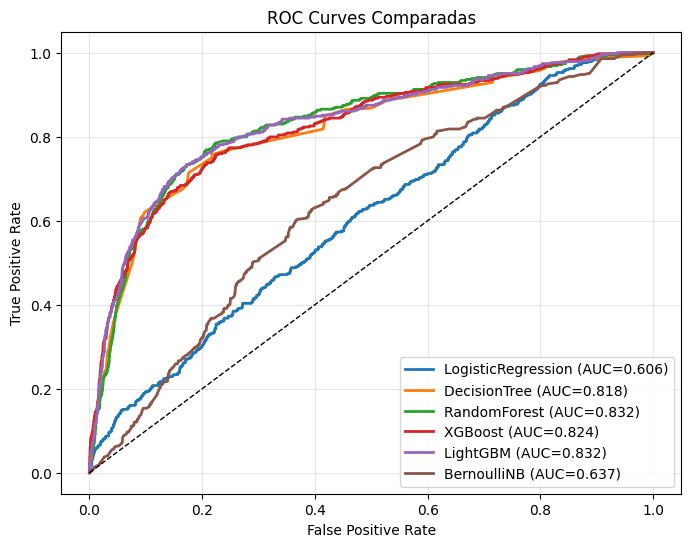

### Comparativa de métricas por modelo (rank por Recall)


,Position,Model,Recall,AUC,Accuracy
0,1°,DecisionTree,0.683962,0.817656,0.817855
1,2°,RandomForest,0.627358,0.831869,0.863007
2,3°,LightGBM,0.591981,0.831918,0.887464
3,4°,XGBoost,0.516509,0.823813,0.894305
4,5°,LogisticRegression,0.448113,0.606363,0.664956
5,6°,BernoulliNB,0.429245,0.636655,0.719001


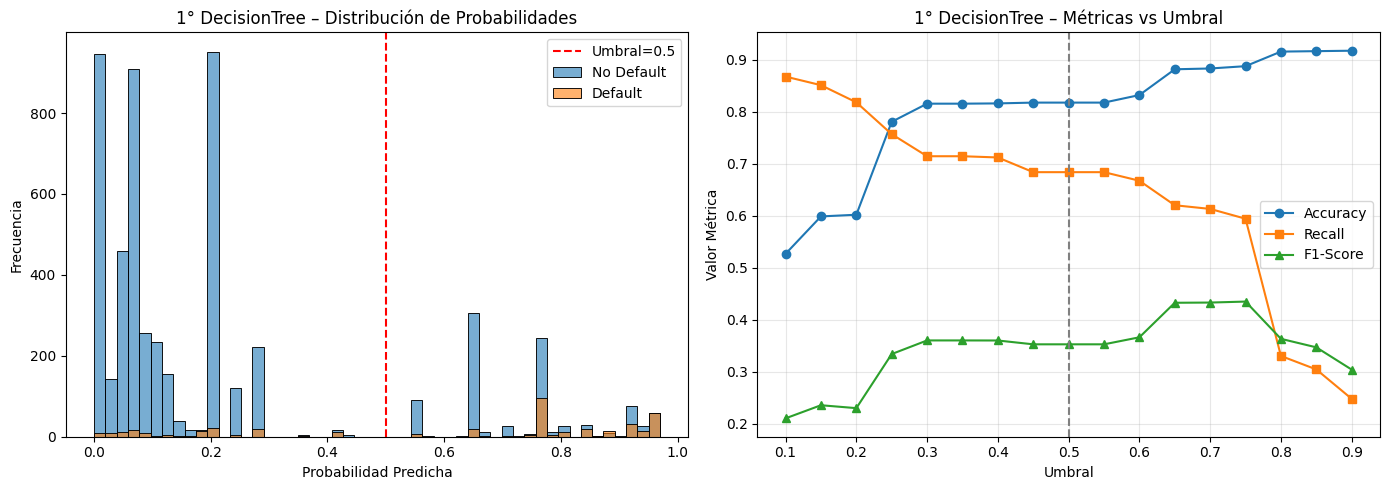

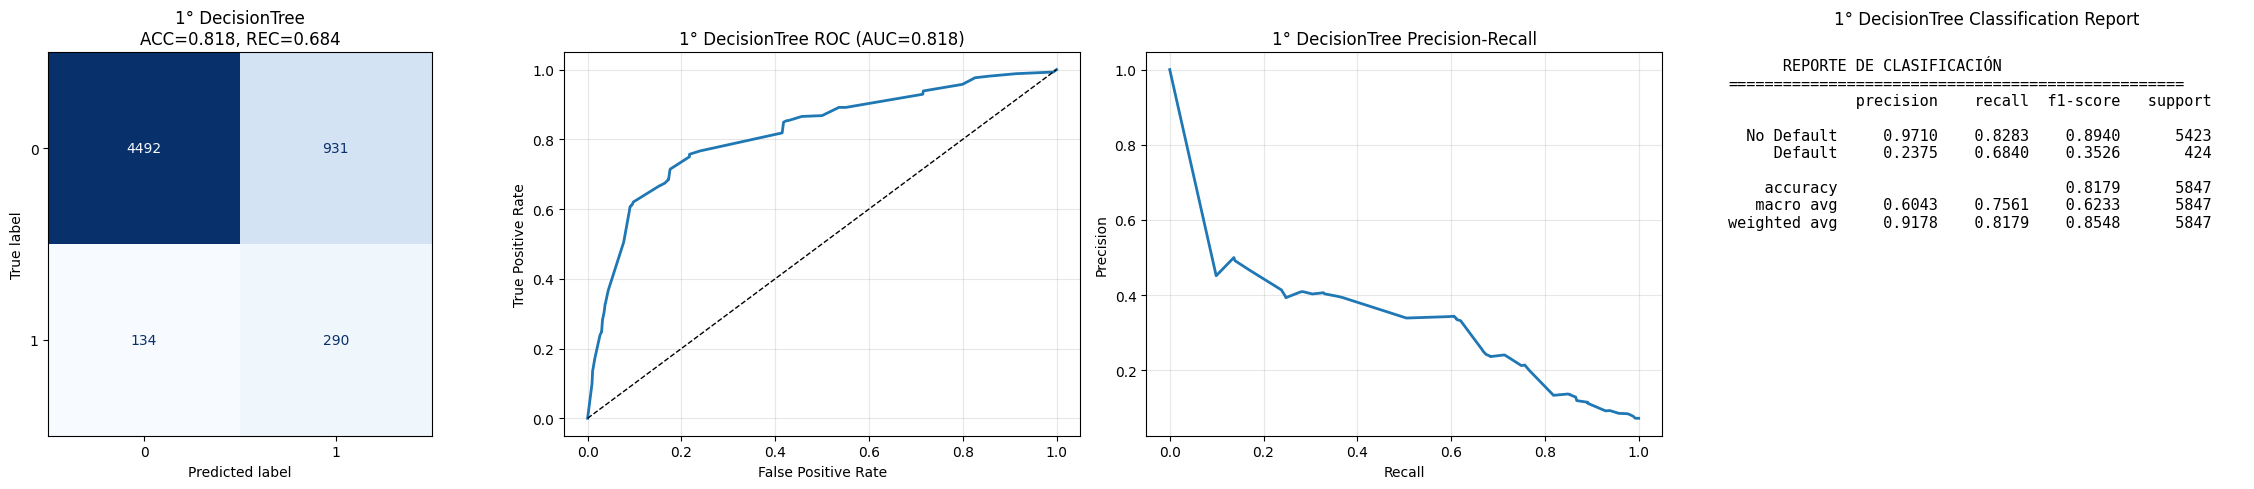

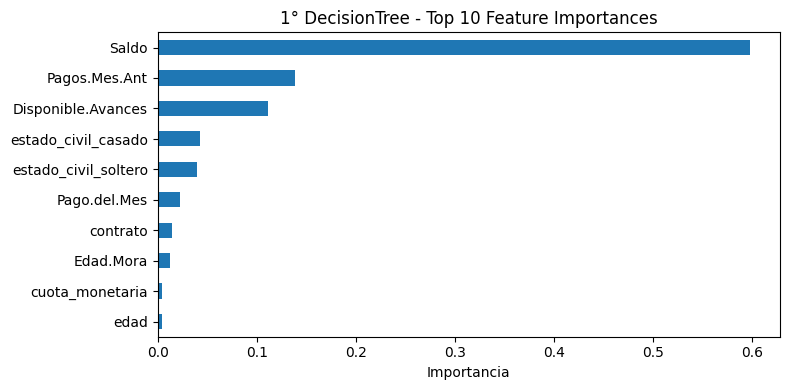

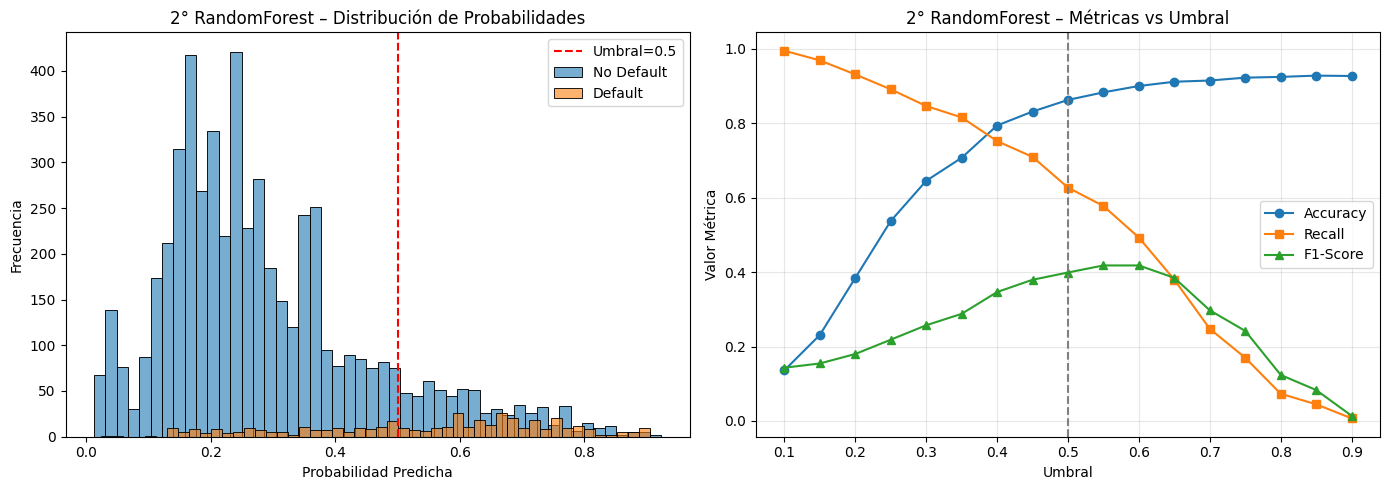

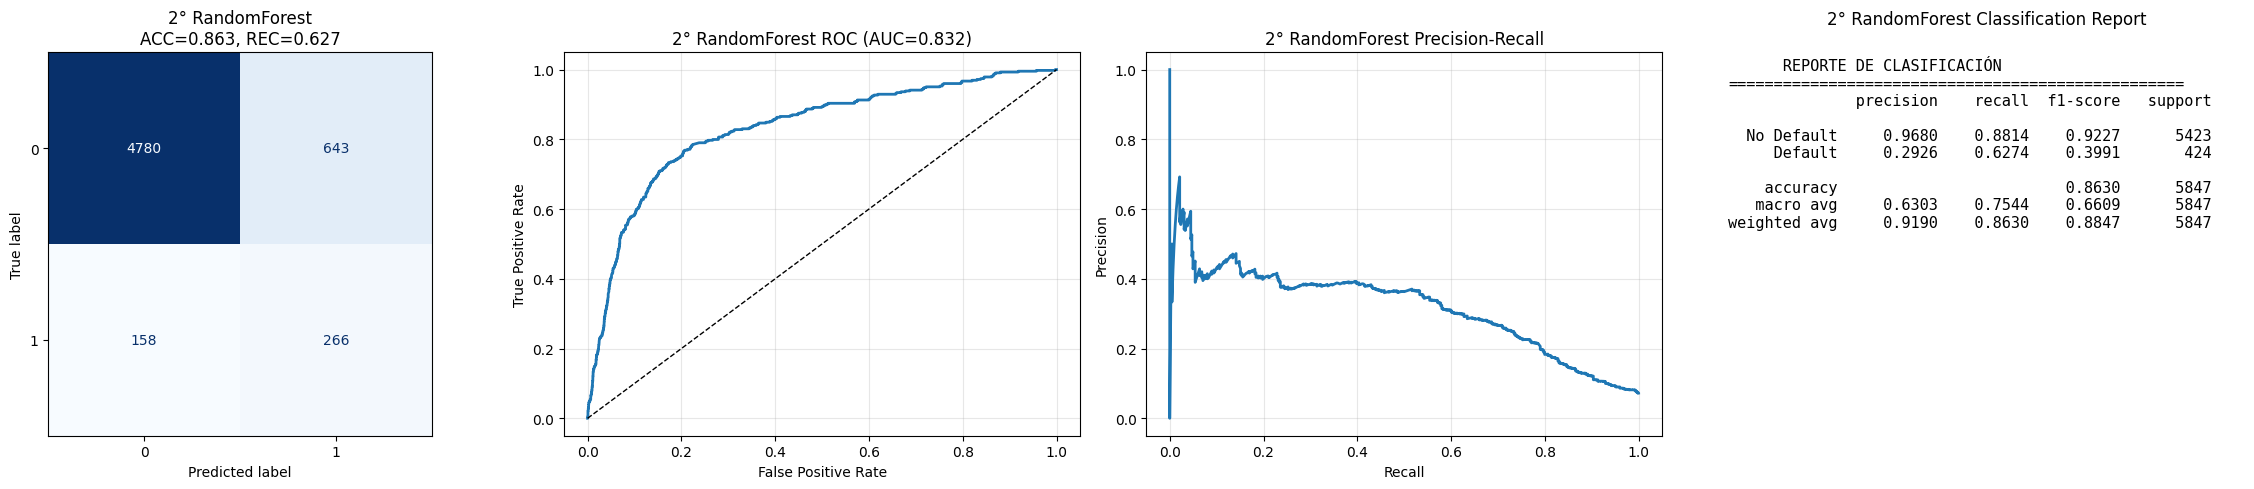

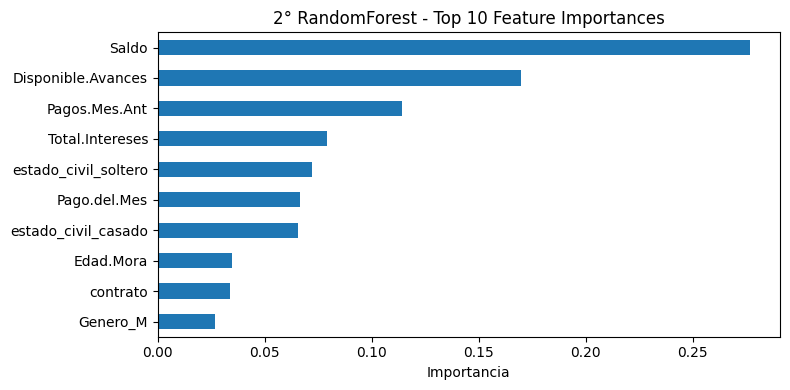

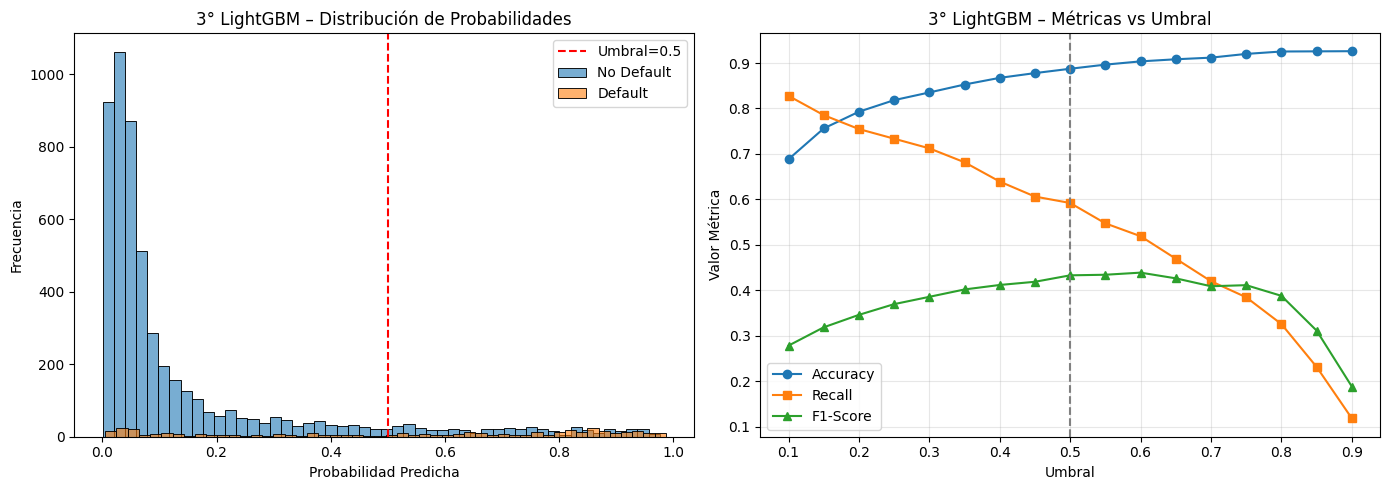

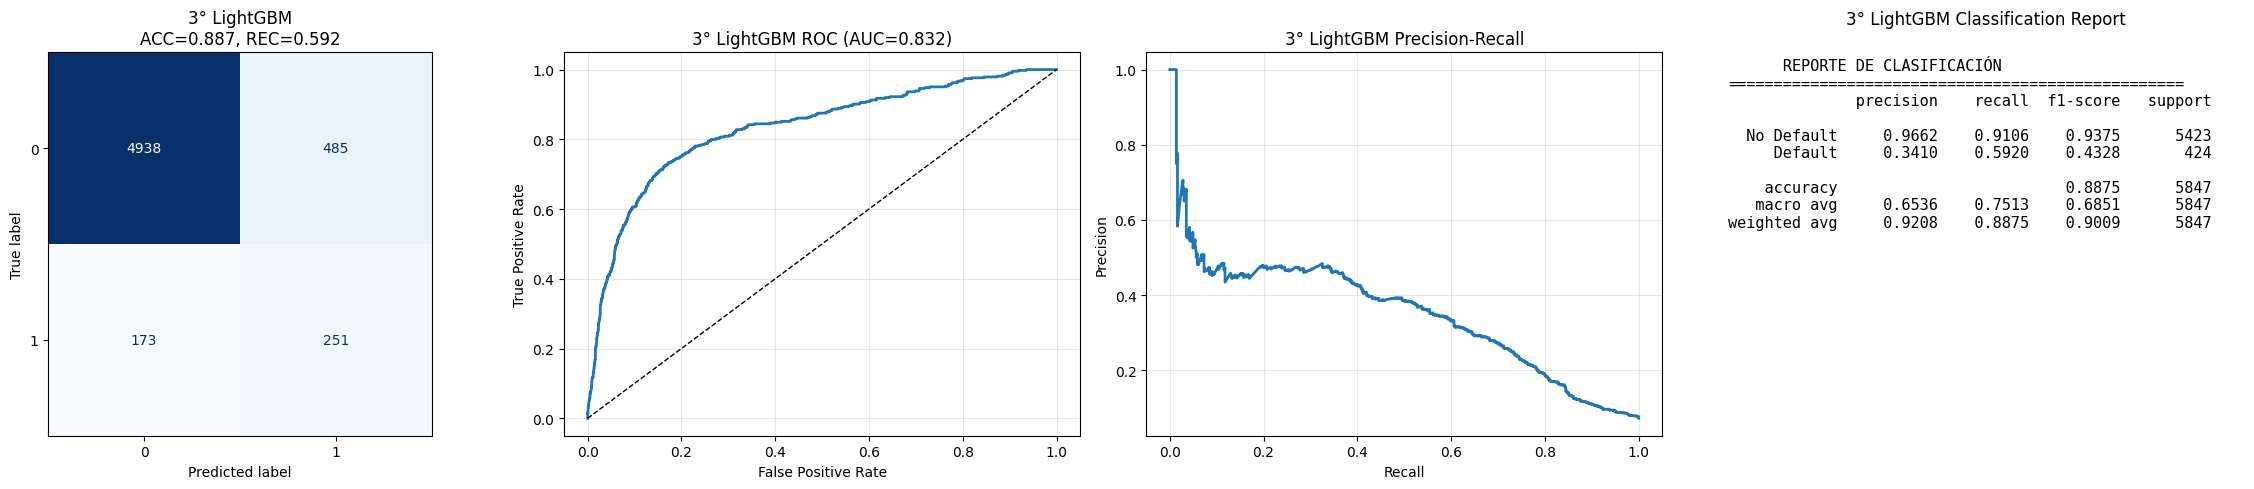

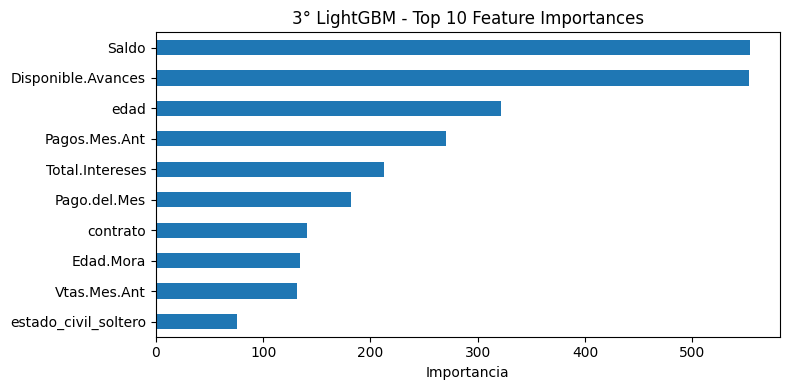

In [24]:

# ==== 2) Entrenar y comparar ROC ====
results = []
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # Para pipelines con .decision_function (p.ej., SVM) o modelos sin predict_proba
        # (la mayoría aquí sí tienen predict_proba)
        if hasattr(model, "decision_function"):
            dec = model.decision_function(X_test)
            y_proba = (dec - dec.min())/(dec.max()-dec.min() + 1e-12)
        else:
            # fallback: usar predicciones duras como probas (no recomendado, pero evita romper el flujo)
            y_proba = y_pred.astype(float)

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.3f})")

    results.append({
        'Model': name,
        'AUC': auc,
        'Accuracy': acc,
        'Recall': rec,
        'Estimator': model
    })

plt.plot([0,1],[0,1],'k--', lw=1)
plt.title("ROC Curves Comparadas")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()



# ==== 3) Ranking por Recall ====
results_df = pd.DataFrame(results)
results_df['Rank'] = results_df['Recall'].rank(method='dense', ascending=False).astype(int)
results_df = results_df.sort_values(['Rank','Model']).reset_index(drop=True)
results_df['Position'] = results_df['Rank'].astype(str) + '°'
print("### Comparativa de métricas por modelo (rank por Recall)")
display(results_df[['Position','Model','Recall','AUC','Accuracy']])

# ==== 4) Profundizar en top-K modelos (umbral, curvas, matriz, reporte, importancias) ====
K = 3  # cantidad de modelos a analizar en detalle
thresholds = np.linspace(0.1, 0.9, 17)
topk = results_df[results_df['Rank'] <= K]

for _, row in topk.iterrows():
    name    = row['Model']
    model   = row['Estimator']
    auc     = row['AUC']
    acc     = row['Accuracy']
    rec     = row['Recall']
    pos     = row['Position']

    # Probabilidades
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        if hasattr(model, "decision_function"):
            dec   = model.decision_function(X_test)
            y_proba = (dec - dec.min())/(dec.max()-dec.min() + 1e-12)
        else:
            y_proba = model.predict(X_test).astype(float)

    y_pred = (y_proba >= 0.5).astype(int)

    # 4.1 Distribución y métricas vs umbral
    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # Histograma
    sns.histplot(y_proba[y_test==0], label='No Default', bins=50, alpha=0.6, ax=axes[0])
    sns.histplot(y_proba[y_test==1], label='Default',   bins=50, alpha=0.6, ax=axes[0])
    axes[0].axvline(0.5, color='red', linestyle='--', label='Umbral=0.5')
    axes[0].set_title(f"{pos} {name} – Distribución de Probabilidades")
    axes[0].set_xlabel("Probabilidad Predicha")
    axes[0].set_ylabel("Frecuencia")
    axes[0].legend()

    # Accuracy, Recall, F1 vs Umbral
    accs, recs, f1s = [], [], []
    for thr in thresholds:
        y_thr = (y_proba >= thr).astype(int)
        accs.append(accuracy_score(y_test, y_thr))
        recs.append(recall_score(y_test, y_thr))
        f1s.append(f1_score(y_test, y_thr))
    axes[1].plot(thresholds, accs, marker='o', label='Accuracy')
    axes[1].plot(thresholds, recs, marker='s', label='Recall')
    axes[1].plot(thresholds, f1s, marker='^', label='F1-Score')
    axes[1].axvline(0.5, color='gray', linestyle='--')
    axes[1].set_title(f"{pos} {name} – Métricas vs Umbral")
    axes[1].set_xlabel("Umbral")
    axes[1].set_ylabel("Valor Métrica")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4.2 Matriz, ROC, PR y Reporte de Clasificación
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, axes = plt.subplots(1, 4, figsize=(24,5))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
    axes[0].set_title(f"{pos} {name}\nACC={acc:.3f}, REC={rec:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[1].plot(fpr, tpr, lw=2)
    axes[1].plot([0,1],[0,1],'k--', lw=1)
    axes[1].set_title(f"{pos} {name} ROC (AUC={auc:.3f})")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].grid(alpha=0.3)

    prec, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    axes[2].plot(rec_curve, prec, lw=2)
    axes[2].set_title(f"{pos} {name} Precision-Recall")
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].grid(alpha=0.3)

    axes[3].axis('off')
    report = classification_report(
        y_test, y_pred,
        target_names=['No Default','Default'], digits=4
    )
    axes[3].text(0, 0.5, "      REPORTE DE CLASIFICACIÓN\n" +
                 "="*50 + "\n" + report,
                 fontfamily='monospace', fontsize=11)
    axes[3].set_title(f"{pos} {name} Classification Report", pad=20)
    plt.tight_layout()
    plt.show()

    # 4.3 Importancias (si existen)
    est = model.named_steps['clf'] if isinstance(model, ImbPipeline) else model
    if hasattr(est, "feature_importances_"):
        imp = pd.Series(est.feature_importances_, index=features).sort_values(ascending=False).head(10)
        plt.figure(figsize=(8,4))
        imp.plot.barh()
        plt.gca().invert_yaxis()
        plt.title(f"{pos} {name} - Top 10 Feature Importances")
        plt.xlabel("Importancia")
        plt.tight_layout()
        plt.show()

### Se seleciona el mejor modelo y se guarda, para proximos usos

In [ ]:

# 1) Seleccionar la fila del mejor modelo (Position == '1°')
best_row   = results_df.loc[results_df['Position'] == '1°'].iloc[0]
best_name  = best_row['Model']
best_auc   = float(best_row['AUC'])
best_rec   = float(best_row['Recall'])
best_acc   = float(best_row['Accuracy'])
best_model = best_row['Estimator']   # ya está entrenado sobre X_train

print(f"✅ Mejor modelo por Recall: {best_name} | AUC={best_auc:.3f} | Recall={best_rec:.3f} | Acc={best_acc:.3f}")

# 2) (Opcional) Calcular umbral óptimo en test (maximiza F1)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    dec = best_model.decision_function(X_test)
    y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-12)
else:
    # si no hay scores, usamos predicción dura (no ideal, pero evita falla)
    y_proba = best_model.predict(X_test).astype(float)

thr_grid = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thr_grid]
best_thr = float(thr_grid[int(np.argmax(f1s))])
best_f1  = float(np.max(f1s))
print(f"⭐ Umbral óptimo (por F1 en test): {best_thr:.3f} | F1={best_f1:.3f}")

# 3) Guardar todo en un solo paquete
artifact = {
    "pipeline": best_model,          # el estimador/pipeline ya entrenado con X_train
    "model_name": best_name,
    "selected_by": "Recall (Position == 1°)",
    "metrics_on_test": {
        "AUC": best_auc,
        "Recall": best_rec,
        "Accuracy": best_acc,
        "Best_F1_at_threshold": best_f1,
        "Threshold": best_thr,
    },
    "features": features,
    "created_at": datetime.now().isoformat(timespec="seconds")
}

joblib.dump(artifact, "best_model_position_1.pkl")
print("💾 Guardado en: best_model_position_1.pkl")


✅ Mejor modelo por Recall: DecisionTree | AUC=0.818 | Recall=0.684 | Acc=0.818
⭐ Umbral óptimo (por F1 en test): 0.750 | F1=0.435
💾 Guardado en: best_model_position_1.pkl


In [28]:
import subprocess

with open('requirements.txt', 'w') as f:
    subprocess.run(['pip', 'freeze'], stdout=f)